In [2]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import hashlib
from ultralytics import YOLO

# Paramètres
base_path = "detection"
train_images_path = os.path.join(base_path, "images/train")
val_images_path = os.path.join(base_path, "images/val")
model_path = "runs/detect/train6/weights/best.pt"  # Chemin vers YOLOv8s
output_dir = "InterestData"  # Dossier pour sauvegarder les ROI
output_csv = "yolo_detections_train_val.csv"  # Fichier CSV pour les métadonnées
conf_threshold = 0.6  # Seuil de confiance optimal
iou_threshold = 0.45  # Seuil IoU pour NMS
iou_match_threshold = 0.3  # Seuil IoU pour appariement
min_box_size = 0.1  # Taille minimale normalisée pour filtrer les petites boîtes
list_disease = {0: "Fito", 1: "Monilia", 2: "Sana"}  # Mapping des classes

# Créer le dossier de sortie
os.makedirs(output_dir, exist_ok=True)

# Charger le modèle YOLOv8s
model = YOLO(model_path)

# Récupérer les images d'entraînement et de validation
train_images = glob.glob(os.path.join(train_images_path, "*.jpg"))
val_images = glob.glob(os.path.join(val_images_path, "*.jpg"))
all_images = train_images + val_images
print(f"Total images (train + val): {len(all_images)}")

# Fonction pour lire les annotations (vérités terrain)
def read_yolo_labels(label_path):
    labels = []
    bboxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    print(f"Format incorrect dans {label_path}: {line}")
                    continue
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                labels.append(class_id)
                bboxes.append([x_center, y_center, width, height])
    return labels, bboxes

# Fonction pour calculer l'IoU entre deux boîtes (format YOLO: [x_center, y_center, width, height])
def calculate_iou(box1, box2):
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2
    
    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2
    
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)
    
    inter_area = max(0, x_inter_max - x_inter_min) * max(0, y_inter_max - y_inter_min)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = area1 + area2 - inter_area
    
    return inter_area / union_area if union_area > 0 else 0

# Liste pour stocker les résultats
results = []

# Effectuer les prédictions et extraire les ROI
for img_path in all_images:
    # Déterminer si l'image est dans train ou val
    if "train" in img_path:
        label_path = img_path.replace("images/train", "labels/train").replace(".jpg", ".txt")
    else:
        label_path = img_path.replace("images/val", "labels/val").replace(".jpg", ".txt")
    
    # Charger l'image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Erreur de chargement de l'image {img_path}")
        continue
    height, width = img.shape[:2]
    
    # Prédire avec YOLO
    results_yolo = model.predict(img_path, conf=conf_threshold, iou=iou_threshold, imgsz=640, verbose=False)
    
    # Récupérer les prédictions
    pred_classes = []
    pred_bboxes = []
    pred_scores = []
    for result in results_yolo:
        if result.boxes is not None:
            pred_classes.extend(result.boxes.cls.cpu().numpy().astype(int))
            pred_bboxes.extend(result.boxes.xywhn.cpu().numpy())  # xywh normalisé
            pred_scores.extend(result.boxes.conf.cpu().numpy())
    
    # Récupérer les vérités terrain
    gt_classes, gt_bboxes = read_yolo_labels(label_path)
    
    # Appariement des boîtes basé sur l'IoU
    used_preds = set()
    used_gts = set()
    
    if pred_bboxes and gt_bboxes:
        # Calculer la matrice IoU
        iou_matrix = np.zeros((len(pred_bboxes), len(gt_bboxes)))
        for i, pred_box in enumerate(pred_bboxes):
            for j, gt_box in enumerate(gt_bboxes):
                iou_matrix[i, j] = calculate_iou(pred_box, gt_box)
        
        # Appariement glouton
        while np.max(iou_matrix) >= iou_match_threshold:
            max_idx = np.unravel_index(np.argmax(iou_matrix), iou_matrix.shape)
            pred_idx, gt_idx = max_idx
            
            pred_class = pred_classes[pred_idx]
            gt_class = gt_classes[gt_idx]
            pred_box = pred_bboxes[pred_idx]
            pred_score = pred_scores[pred_idx]
            iou = iou_matrix[max_idx]
            
            # Filtrer les boîtes trop petites
            if pred_box[2] < min_box_size or pred_box[3] < min_box_size:
                used_preds.add(pred_idx)
                used_gts.add(gt_idx)
                iou_matrix[pred_idx, :] = -1
                iou_matrix[:, gt_idx] = -1
                continue
            
            # Conversion en coordonnées absolues
            x_center = pred_box[0] * width
            y_center = pred_box[1] * height
            box_width = pred_box[2] * width
            box_height = pred_box[3] * height
            
            x_min = int(max(x_center - box_width / 2, 0))
            y_min = int(max(y_center - box_height / 2, 0))
            x_max = int(min(x_center + box_width / 2, width))
            y_max = int(min(y_center + box_height / 2, height))
            
            # Extraction de la ROI
            roi = img[y_min:y_max, x_min:x_max]
            if roi.size == 0:
                print(f"ROI vide pour {img_path}, boîte {pred_idx}")
                continue
            
            # Génération d'un identifiant unique
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            hash_object = hashlib.md5(f"{base_name}_class{pred_class}_roi{pred_idx}".encode())
            identifiant = hash_object.hexdigest()[:8]
            
            # Sauvegarde de la ROI
            output_filename = f"class{pred_class}_{identifiant}.jpg"
            output_path = os.path.join(output_dir, output_filename)
            cv2.imwrite(output_path, roi)
            print(f"ROI enregistrée: {output_path}")
            
            # Stocker les métadonnées
            results.append({
                "image_path": img_path,
                "output_path": output_path,
                "pred_x_center": pred_box[0],
                "pred_y_center": pred_box[1],
                "pred_width": pred_box[2],
                "pred_height": pred_box[3],
                "pred_class": pred_class,
                "pred_class_name": list_disease[pred_class],
                "gt_class": gt_class,
                "gt_class_name": list_disease[gt_class],
                "confidence": pred_score,
                "iou": iou,
                "dataset": "train" if "train" in img_path else "val"
            })
            
            used_preds.add(pred_idx)
            used_gts.add(gt_idx)
            iou_matrix[pred_idx, :] = -1
            iou_matrix[:, gt_idx] = -1
    
    # Ajouter les prédictions non appariées (optionnel)
    for i, pred_class in enumerate(pred_classes):
        if i not in used_preds:
            pred_box = pred_bboxes[i]
            if pred_box[2] < min_box_size or pred_box[3] < min_box_size:
                continue
            results.append({
                "image_path": img_path,
                "output_path": None,
                "pred_x_center": pred_box[0],
                "pred_y_center": pred_box[1],
                "pred_width": pred_box[2],
                "pred_height": pred_box[3],
                "pred_class": pred_class,
                "pred_class_name": list_disease[pred_class],
                "gt_class": None,
                "gt_class_name": None,
                "confidence": pred_scores[i],
                "iou": 0.0,
                "dataset": "train" if "train" in img_path else "val"
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Sauvegarder les résultats dans un fichier CSV
results_df.to_csv(output_csv, index=False)
print(f"✅ Résultats sauvegardés dans {output_csv}")

# Afficher un aperçu des résultats
print("\n📊 Aperçu des résultats :")
print(results_df.head())

# Statistiques
total_predictions = len(results_df[results_df["pred_class"].notnull()])
total_gt = len(results_df[results_df["gt_class"].notnull()])
matched = len(results_df[(results_df["pred_class"].notnull()) & (results_df["gt_class"].notnull())])
print(f"\n📊 Statistiques :")
print(f"Total prédictions : {total_predictions}")
print(f"Total vérités terrain : {total_gt}")
print(f"Appariements réussis : {matched}")
print(f"Pourcentage d'appariement : {matched / total_gt * 100:.2f}%")

Total images (train + val): 312
ROI enregistrée: InterestData\class0_23a06f61.jpg
ROI enregistrée: InterestData\class2_7369eb32.jpg
ROI enregistrée: InterestData\class0_d03b12e7.jpg
ROI enregistrée: InterestData\class2_d97125f7.jpg
ROI enregistrée: InterestData\class0_7cfe01ef.jpg
ROI enregistrée: InterestData\class2_7498cd7d.jpg
ROI enregistrée: InterestData\class2_fe6b4a31.jpg
ROI enregistrée: InterestData\class2_0c60bf27.jpg
ROI enregistrée: InterestData\class1_624e36dd.jpg
ROI enregistrée: InterestData\class0_5bc0176b.jpg
ROI enregistrée: InterestData\class0_a14fd65d.jpg
ROI enregistrée: InterestData\class2_ba9a3aff.jpg
ROI enregistrée: InterestData\class2_9a16ebb2.jpg
ROI enregistrée: InterestData\class2_480b7d38.jpg
ROI enregistrée: InterestData\class2_a5fa37a8.jpg
ROI enregistrée: InterestData\class2_8c426b51.jpg
ROI enregistrée: InterestData\class2_02e48afb.jpg
ROI enregistrée: InterestData\class2_33cdd1f4.jpg
ROI enregistrée: InterestData\class0_53ca9e05.jpg
ROI enregistrée: I

In [1]:
import os
import shutil
import random

random.seed(42)

# Configuration
source_dir = "InterestData"

train_dir = "Dataset/train"
val_dir = "Dataset/validation"
split_ratio = 0.8  # 80% train / 20% validation

# Création des répertoires
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Dictionnaire pour regrouper les fichiers par classe
class_files = {}

# Remplir le dictionnaire avec les fichiers classés par classe
for filename in os.listdir(source_dir):
    if filename.endswith(".jpg"):
        try:
            class_id = filename.split("_")[0][5:]  # Extraction du class_id
            class_files.setdefault(class_id, []).append(filename)
        except:
            print(f"Format invalide pour {filename}")
            continue

# Répartition stratifiée
for class_id, files in class_files.items():
    random.shuffle(files)  # Mélange aléatoire
    split_idx = int(len(files) * split_ratio)
    
    # Déplacement vers train
    for file in files[:split_idx]:
        src = os.path.join(source_dir, file)
        dst = os.path.join(train_dir, file)
        shutil.move(src, dst)
    
    # Déplacement vers validation
    for file in files[split_idx:]:
        src = os.path.join(source_dir, file)
        dst = os.path.join(val_dir, file)
        shutil.move(src, dst)

print(f"Répartition terminée :")
print(f"- Train: {len(os.listdir(train_dir))} images")
print(f"- Validation: {len(os.listdir(val_dir))} images")

Répartition terminée :
- Train: 577 images
- Validation: 147 images


## IMPLEMENTATION CONVNEXT 

In [2]:
import os
import shutil
import random
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# Fixer les graines pour la reproductibilité
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Paramètres
batch_size = 32
img_size = (224, 224)
num_classes = 3  # Adapté à vos 3 maladies

# Paramètres d'augmentation
augmentation_params = {
    "flip_horizontal": True,  # Retournement horizontal
    "flip_vertical": True,   # Retournement vertical
    "rotation": 30.0,        # Rotation max en degrés
    "zoom": 0.2,             # Zoom max (0.2 = ±20%)
    "translation_height": 0.1,  # Translation max verticale (10% de l'image)
    "translation_width": 0.1,
    "brightness": 0.2,       # Variation max de luminosité
    "contrast": [0.8, 1.2],  # Plage de contraste
    "noise_std": 10.0,       # Écart-type du bruit gaussien
    "crop": 0.1              # Recadrage aléatoire max (10% de l'image)
}

# Définir la couche RandomTranslation globalement
translation_layer = tf.keras.layers.RandomTranslation(
    height_factor=augmentation_params["translation_height"],
    width_factor=augmentation_params["translation_width"],
    fill_mode="nearest"
)

# Fonctions utilitaires pour le pipeline
# Pipeline de données avec augmentation
def parse_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.keras.applications.convnext.preprocess_input(image)
    return image

def augment_image(image, params):
    # Flip horizontal et vertical
    if params["flip_horizontal"]:
        image = tf.image.random_flip_left_right(image)
    if params["flip_vertical"]:
        image = tf.image.random_flip_up_down(image)
    
    # Rotation
    if params["rotation"] > 0:
        angle = tf.random.uniform([], -params["rotation"] * np.pi / 180, params["rotation"] * np.pi / 180)
        image = tf.image.rot90(image, k=tf.cast(angle / (np.pi / 2), tf.int32))
    
    # Zoom
    if params["zoom"] > 0:
        scale = tf.random.uniform([], 1 - params["zoom"], 1 + params["zoom"])
        new_size = tf.cast(tf.cast(img_size, tf.float32) * scale, tf.int32)
        image = tf.image.resize(image, new_size)
        image = tf.image.resize_with_crop_or_pad(image, img_size[0], img_size[1])
    
    # Translation (utilisation de la couche globale)
    if params["translation_height"] > 0 or params["translation_width"] > 0:
        image = translation_layer(image)
    
    # Luminosité
    if params["brightness"] > 0:
        image = tf.image.random_brightness(image, max_delta=params["brightness"])
    
    # Contraste
    if params["contrast"][0] < params["contrast"][1]:
        image = tf.image.random_contrast(image, lower=params["contrast"][0], upper=params["contrast"][1])
    
    # Bruit gaussien
    if params["noise_std"] > 0:
        noise = tf.random.normal(tf.shape(image), stddev=params["noise_std"])
        image = image + noise
    
    # Recadrage aléatoire
    if params["crop"] > 0:
        crop_size = tf.cast(tf.cast(img_size, tf.float32) * (1 - params["crop"]), tf.int32)
        image = tf.image.random_crop(image, size=[crop_size[0], crop_size[1], 3])
        image = tf.image.resize(image, img_size)
    
    # Clip pour éviter des valeurs aberrantes
    image = tf.clip_by_value(image, 0, 255)
    return image

def get_label_from_filename(filename):
    fname = tf.strings.split(filename, os.sep)[-1]
    label_str = tf.strings.regex_replace(fname, "^class", "")
    label_str = tf.strings.split(label_str, "_")[0]
    label = tf.strings.to_number(label_str, out_type=tf.int32)
    return tf.one_hot(label, depth=num_classes)

def load_and_preprocess_image(filename, augment=False):
    image = parse_image(filename)
    if augment:
        image = augment_image(image, augmentation_params)
    label = get_label_from_filename(filename)
    return image, label

# Création des datasets
train_files = tf.data.Dataset.list_files(os.path.join(train_dir, "*.jpg"), shuffle=True)
val_files = tf.data.Dataset.list_files(os.path.join(val_dir, "*.jpg"), shuffle=False)

train_ds = train_files.map(lambda x: load_and_preprocess_image(x, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_files.map(lambda x: load_and_preprocess_image(x, augment=False), num_parallel_calls=tf.data.AUTOTUNE)

# Regroupement en batches et optimisation par prefetch
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds  = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [3]:
# Vérifier la taille de train_ds via cardinality (optionnel)
train_size = tf.data.experimental.cardinality(train_files).numpy()
print(f"Taille de train_ds (images avant batching) : {train_size}")

Taille de train_ds (images avant batching) : 577


### 1-Création du modèle ConvNeXtSmall

In [14]:
# -------------------------------------------
# Construction du modèle avec ConvNeXtSmall
# -------------------------------------------

# Charger la base pré-entraînée ConvNeXtSmall sans la tête (include_top=False)
# Création du modèle ConvNeXtSmall
base_model = tf.keras.applications.ConvNeXtSmall(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size[0], img_size[1], 3)
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

# Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_small (Functional)     │ (None, 7, 7, 768)      │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         2,307 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,456,995 (188.66 MB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 49,454,688 (188.65 MB)

#### Entraînement initial et Fine-tuning

In [15]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [ ]:
# -------------------------------------------
# Étape 2 et 3 : Entraînement initial et Fine-tuning
# -------------------------------------------

# Entraînement initial (seulement la nouvelle tête)
# Entraînement initial
initial_epochs = 10
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

# Fine-tuning
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.8)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 603s 31s/step - accuracy: 0.6048 - loss: 0.9776 - precision_2: 0.6129 - recall_2: 0.4871 - val_accuracy: 0.6803 - val_loss: 0.7463 - val_precision_2: 0.7385 - val_recall_2: 0.6531 - learning_rate: 0.0010
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 698s 37s/step - accuracy: 0.7020 - loss: 0.7747 - precision_2: 0.7267 - recall_2: 0.6527 - val_accuracy: 0.7415 - val_loss: 0.6511 - val_precision_2: 0.7886 - val_recall_2: 0.6599 - learning_rate: 0.0010
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 546s 28s/step - accuracy: 0.7201 - loss: 0.6451 - precision_2: 0.7786 - recall_2: 0.6774 - val_accuracy: 0.7755 - val_loss: 0.6093 - val_precision_2: 0.8080 - val_recall_2: 0.6871 - learning_rate: 0.0010
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 363s 20s/step - accuracy: 0.8011 - loss: 0.4967 - precision_2: 0.8431 - recall_2: 0.7546 - val_accuracy: 0.7619 - val_loss: 0.5878 - val_precision_2: 0.8065 - val_recall_2: 0.6803 - learning_rate: 0.0010
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━

#### Evaluation du modèle

In [18]:
class_names = ["Fito", "Monilia", "Sana"]
# Évaluation
y_pred_prob = model.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in val_ds])

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(y_true, y_pred, target_names=class_names))



5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step

Rapport de classification :
              precision    recall  f1-score   support

        Fito       0.78      0.60      0.68        30
     Monilia       0.75      0.60      0.67        20
        Sana       0.87      0.97      0.92        97

    accuracy                           0.84       147
   macro avg       0.80      0.72      0.75       147
weighted avg       0.84      0.84      0.83       147



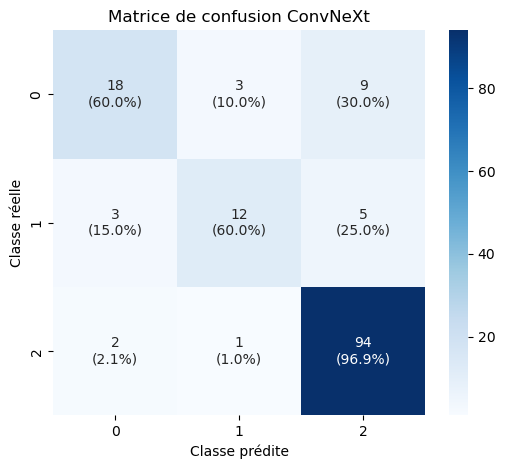

In [19]:
# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
cm_perc = (cm / cm.sum(axis=1, keepdims=True).astype(float)) * 100
labels = np.array([[f"{cm[i,j]}\n({cm_perc[i,j]:.1f}%)" for j in range(num_classes)] for i in range(num_classes)])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion ConvNeXt")
plt.savefig("svg/ConfusionMatrix.svg", format="svg")
plt.show()

Clé manquante : precision ou precision_1
Clé manquante : recall ou recall_1
Clé manquante : val_precision ou val_precision_1
Clé manquante : val_recall ou val_recall_1
Clés dans history_combined: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


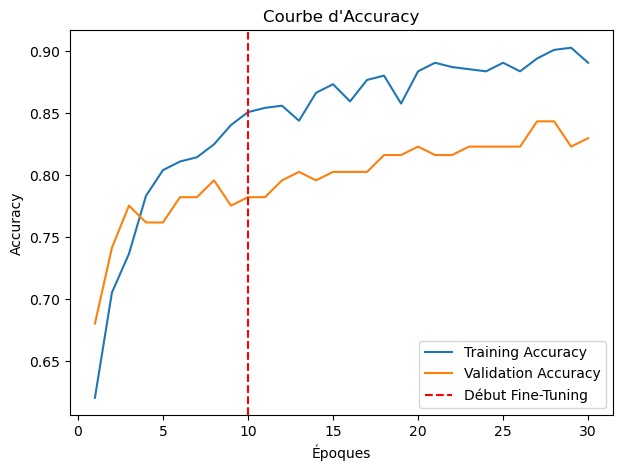

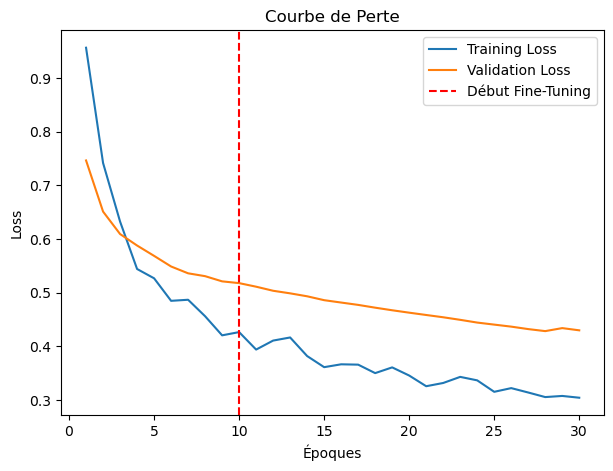

In [20]:
# Courbes d'entraînement
def save_and_show_plot(x, y_train, y_val, title, ylabel, filename):
    plt.figure(figsize=(7, 5))
    plt.plot(x, y_train, label=f"Training {ylabel}")
    plt.plot(x, y_val, label=f"Validation {ylabel}")
    plt.axvline(x=initial_epochs, color='r', linestyle='--', label="Début Fine-Tuning")
    plt.legend()
    plt.title(title)
    plt.xlabel("Époques")
    plt.ylabel(ylabel)
    plt.savefig(f"svg/{filename}", format="svg")
    plt.show()

#Mapper les clés correspondantes pour combiner les historiques
history_combined = {}
metric_mapping = {
    'loss': 'loss',
    'accuracy': 'accuracy',
    'val_loss': 'val_loss',
    'val_accuracy': 'val_accuracy',
    'precision': 'precision_1',  # Mapper precision à precision_1 pour history_fine
    'recall': 'recall_1',        # Mapper recall à recall_1 pour history_fine
    'val_precision': 'val_precision_1',
    'val_recall': 'val_recall_1'
}

for orig_key, fine_key in metric_mapping.items():
    if orig_key in history.history and fine_key in history_fine.history:
        history_combined[orig_key] = history.history[orig_key] + history_fine.history[fine_key]
    else:
        print(f"Clé manquante : {orig_key} ou {fine_key}")

# Ignorer learning_rate (non nécessaire pour les courbes)
if 'learning_rate' in history_combined:
    del history_combined['learning_rate']

# Vérifier les clés combinées
print("Clés dans history_combined:", list(history_combined.keys()))

epochs_range = range(1, len(history_combined.get("accuracy", [])) + 1)

# Tracer les métriques disponibles
if 'accuracy' in history_combined:
    save_and_show_plot(epochs_range, history_combined["accuracy"], history_combined["val_accuracy"], "Courbe d'Accuracy", "Accuracy", "accuracy.svg")
if 'loss' in history_combined:
    save_and_show_plot(epochs_range, history_combined["loss"], history_combined["val_loss"], "Courbe de Perte", "Loss", "loss.svg")
if 'precision' in history_combined:
    save_and_show_plot(epochs_range, history_combined["precision"], history_combined["val_precision"], "Courbe de Précision", "Precision", "precision.svg")
if 'recall' in history_combined:
    save_and_show_plot(epochs_range, history_combined["recall"], history_combined["val_recall"], "Courbe de Rappel", "Recall", "recall.svg")

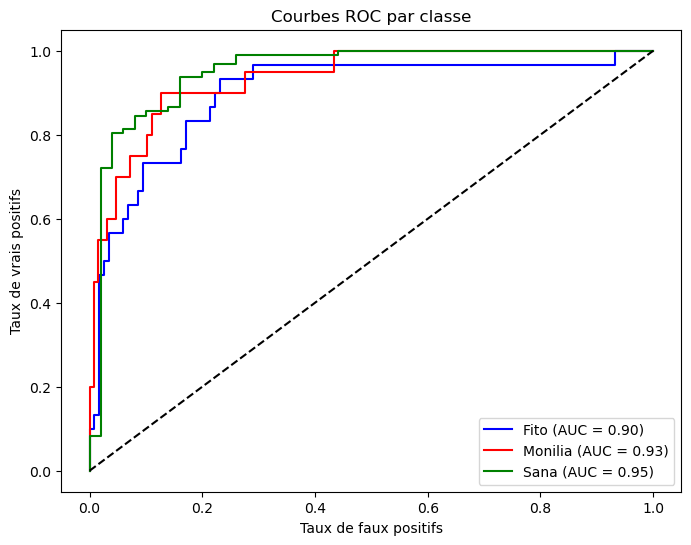

In [21]:
# Courbes ROC
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green"])
for i, color in zip(range(num_classes), colors):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbes ROC par classe")
plt.legend(loc="lower right")
plt.savefig("svg/ROC-AUC.svg", format="svg")
plt.show()


Nombre d'erreurs : 23
                                 file_path  true_label  pred_label  confidence
0   Dataset\validation\class0_003bc8f7.jpg           0           1    0.758135
1   Dataset\validation\class0_0ad3aa11.jpg           0           2    0.711620
9   Dataset\validation\class0_3f8ddc98.jpg           0           2    0.447925
10  Dataset\validation\class0_4d9821af.jpg           0           2    0.987612
12  Dataset\validation\class0_552f6453.jpg           0           2    0.762784


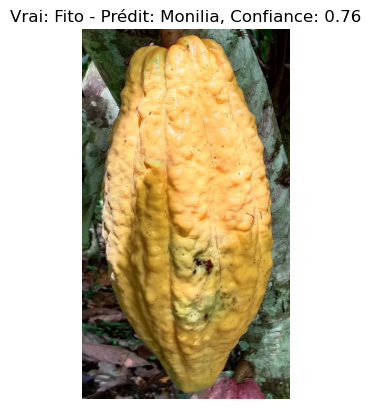

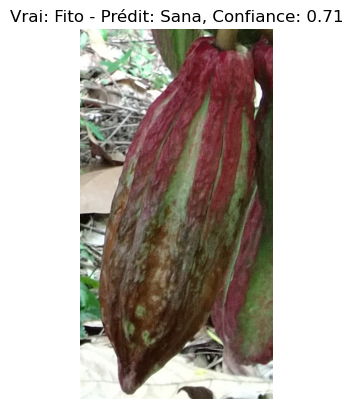

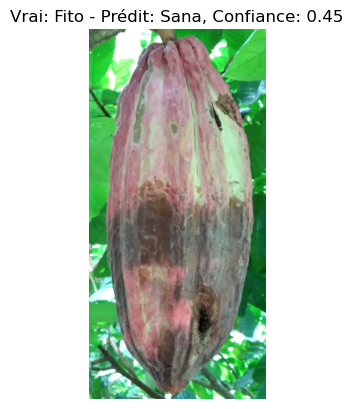

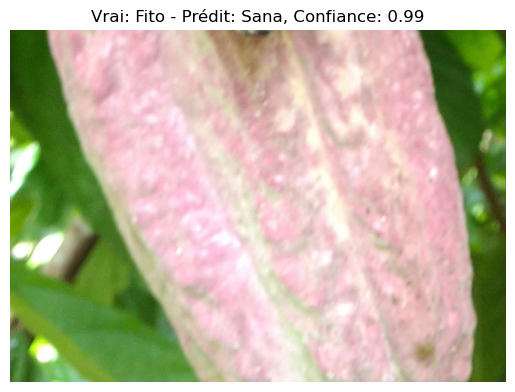

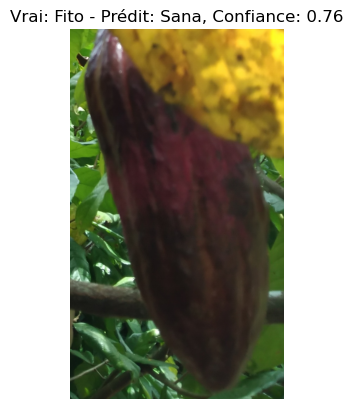

In [22]:
import cv2
# Visualisation des erreurs
df_errors = pd.DataFrame({
    "file_path": [f.numpy().decode() for f in val_files],
    "true_label": y_true,
    "pred_label": y_pred,
    "confidence": np.max(y_pred_prob, axis=1)
})
df_errors = df_errors[df_errors["true_label"] != df_errors["pred_label"]]
print(f"\nNombre d'erreurs : {len(df_errors)}")
print(df_errors.head())

for idx, row in df_errors.head(5).iterrows():
    img = cv2.imread(row["file_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Vrai: {class_names[int(row['true_label'])]} - Prédit: {class_names[int(row['pred_label'])]}, Confiance: {row['confidence']:.2f}")
    plt.axis('off')
    plt.show()


In [23]:
# Sauvegarde du modèle
model.save("Model/convnext_small_final3.keras")